In [22]:
using Pkg
Pkg.activate("/home/users/shubhgup/Codes/Julia/TISExperiments.jl")

  Activating environment at `~/Codes/Julia/TISExperiments.jl/Project.toml`


In [23]:
using Revise

In [24]:
using POMDPs, POMDPGym, POMDPSimulators, POMDPPolicies, Distributions
using BSON
using SARSOP, Random
using POMCPOW
using BeliefUpdaters
using ParticleFilters
using FileIO
using TISExperiments
using POMDPGifs
using D3Trees
# using Interact
using TreeImportanceSampling
include("lander_pomdp.jl")

In [25]:
# using WebIO
# WebIO.install_jupyter_nbextension()
# using Conda
# Conda.pip_interop(true)
# Conda.pip("install", "webio_jupyter_extension")

In [26]:
using Plots
using ProgressMeter

In [27]:
Random.seed!(42)
pomdp = LunarLander()

LunarLander(0.5, 1.0, 10.0, [0.0, 0.0, 0.0, 0.1, 0.1, 0.01], [1.0, 0.01, 0.1])

In [28]:
solver = POMCPOWSolver(criterion=MaxUCB(20.0))

policy = POMDPs.solve(solver, pomdp);

In [29]:
dt = 0.1; # Do not change
maxT = 2.0; # Do not change

In [30]:
function init_particle_belief(pomdp)
    dist = POMDPs.initialstate_distribution(pomdp)
    return ParticleCollection([rand(dist) for i=1:50])
end

init_particle_belief (generic function with 1 method)

In [31]:
costfn(x) = get_cost(x[1][2], x[2], x[3]; dt=dt)

costfn (generic function with 1 method)

In [32]:
amdp = RPOMDP(pomdp=pomdp, π=policy, updater=BootstrapFilter(pomdp, 50), initial_belief_distribution = init_particle_belief(pomdp), cost_fn=costfn, dt=dt, maxT=maxT)

RPOMDP{Vector{Float64}, Vector{Float64}, Vector{Float64}}
  pomdp: LunarLander
  π: POMCPOWPlanner{LunarLander, POMCPOW.POWNodeFilter, MaxUCB, MCTS.RandomActionGenerator{Random._GLOBAL_RNG}, BasicPOMCP.SolvedPORollout{RandomPolicy{Random._GLOBAL_RNG, LunarLander, NothingUpdater}, NothingUpdater, Random._GLOBAL_RNG}, Int64, Float64, POMCPOWSolver{Random._GLOBAL_RNG, POMCPOW.var"#6#12"}}
  updater: BasicParticleFilter{LunarLander, LunarLander, LowVarianceResampler, Random._GLOBAL_RNG, Vector{Vector{Float64}}}
  initial_belief_distribution: ParticleCollection{Vector{Float64}}
  cost_fn: costfn (function of type typeof(costfn))
  dt: Float64 0.1
  maxT: Float64 2.0


In [33]:
POMDPs.observation(pomdp::LunarLander, a, s) = get_observation(s, a)
POMDPs.observation(pomdp::LunarLander, a, s, x) = get_observation_noisy(s, a, x)

POMDPs.actions(mdp::RPOMDP, s) = disturbance(mdp, s)

In [34]:
# Assumes implemented noise-control version of observation `POMDPs.observation(pomdp, a, s, x)`

function POMDPs.gen(mdp::RPOMDP, st, x, rng::AbstractRNG = Random.GLOBAL_RNG; kwargs...)
    t, s, b = st
    
    try
        a = action(mdp.π, b)
        sp, r = @gen(:sp,:r)(mdp.pomdp, s, a, rng)
        o = POMDPs.observation(pomdp, a, sp, x)

        cost = mdp.cost_fn((;st, a, sp, o, r)) # Rmax - r

        b = update(mdp.updater, b, a, o)
        
        return (sp=Any[t+mdp.dt, sp, b], r=cost)
    catch e
#         println("Forcing termination")
        
        t = mdp.maxT
        a = rand(actions(mdp, s))
        sp, r = @gen(:sp,:r)(mdp.pomdp, s, a, rng)
        o = POMDPs.observation(pomdp, a, sp, x)
        cost = mdp.cost_fn((;st, a, sp, o, r))
        
        return (sp=Any[t+mdp.dt, sp, b], r=cost)
    end
end

In [35]:
function POMDPModelTools.render(pomdp::LunarLander, step)
    p = plot(xlim = (0, 10))
    for i=1:6
        scatter!([step.t], [step.s[2][i]], label="state $(i)")
    end
    p
end

POMDPModelTools.render(mdp::RPOMDP, step) = POMDPModelTools.render(mdp.pomdp, step)

In [118]:
function disturbance(m::typeof(amdp), s)
    x_z = [0.0, 20]
    x_ω = [0.0, 0.02]
    x_x = [0.0, 0.2]
    σz = 5.0
    σω = 0.05
    σx = 0.5
    p_z = [pdf(Normal(0.0, σz), x) for x in x_z]
    p_ω = [pdf(Normal(0.0, σω), x) for x in x_ω]
    p_x = [pdf(Normal(0.0, σx), x) for x in x_x]
    
    xs = [Iterators.product(x_z, x_ω, x_x)...]
    xs = [[x...] for x in xs]
    ps = [Iterators.product(p_z, p_ω, p_x)...]
    ps = [prod(p) for p in ps]
#     ps = ones(length(xs))
    ps ./= sum(ps)
    px = GenericDiscreteNonParametric(xs, ps)
    return px
end

disturbance (generic function with 1 method)

In [90]:
fixed_s = rand(initialstate(amdp));

In [119]:
actions(amdp, fixed_s)

GenericDiscreteNonParametric([[0.0, 0.0, 0.0], [20.0, 0.0, 0.0], [0.0, 0.02, 0.0], [20.0, 0.02, 0.0], [0.0, 0.0, 0.2], [20.0, 0.0, 0.2], [0.0, 0.02, 0.2], [20.0, 0.02, 0.2]], DiscreteNonParametric{Int64, Float64, Vector{Int64}, Vector{Float64}}(
support: [1, 2, 3, 4, 5, 6, 7, 8]
p: [0.27029823891789256, 9.067495754481723e-5, 0.2495167227446269, 8.3703535517535e-5, 0.2495167227446269, 8.3703535517535e-5, 0.23033296546238718, 7.726810188659091e-5]
)
)

In [120]:
N = 1000
# N = 10_000
c = 3e-1
α = 0.01

β = 0.01
γ = 0.01

schedule = 1.0 # set to Inf to switch off

uniform_floor = 1e-6 # set to 0.0 to switch off

baseline = false
base_continue = false

path = "data/lander";

if base_continue
    baseline_costs = load("$(path)_baseline_$(N).jld2")["risks"]
else
    baseline_costs = []
end


Any[]

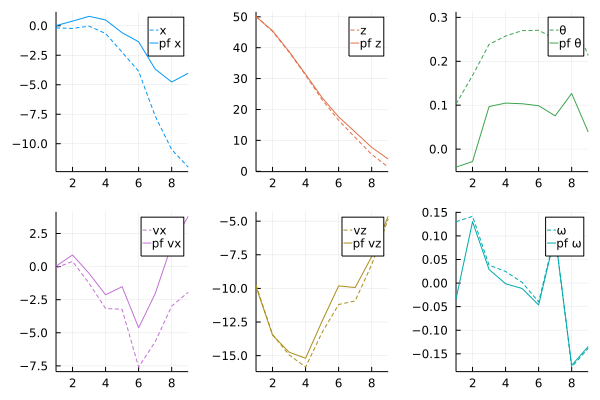

In [101]:
function plot_path(history)
    state_l = hcat([step.s[2] for step in history]...)
    pf_state_l = hcat([mean(step.s[3]) for step in history]...)
    costs_l = [step.r for step in history]
    labels = ['x', 'z', 'θ', "vx", "vz", 'ω']
    plots = []
    for i=1:6
        p = plot(xlim = (1, length(history)))
        plot!(state_l[i, :], label=labels[i], linestyle=:dash, color=i)
        plot!(pf_state_l[i, :], label="pf $(labels[i])", color=i)
        push!(plots, p)
    end
#     p = plot(xlim = (1, length(history)))
#     plot!(costs_l, label="r")
#     push!(plots, p)
    
    plot(plots...)
end

# history = simulate(HistoryRecorder(), amdp, FunctionPolicy((s) -> rand(disturbance(amdp, s))), fixed_s);
history = simulate(HistoryRecorder(), amdp, FunctionPolicy((s) -> [0.0, 0.0, 0.0]), fixed_s);
plot_path(history)

In [121]:
@showprogress for i=1:N
    cost = sum(collect(simulate(HistoryRecorder(), amdp, FunctionPolicy((s) -> rand(disturbance(amdp, s))), fixed_s)[:r]))
#     cost = sum(collect(simulate(HistoryRecorder(), amdp, FunctionPolicy((s) -> [0.0, 0.0, 0.0]), fixed_s)[:r]))
    push!(baseline_costs, cost)
end
# baseline_costs_1 = baseline_costs

Progress: 100%|█████████████████████████████████████████| Time: 0:00:39


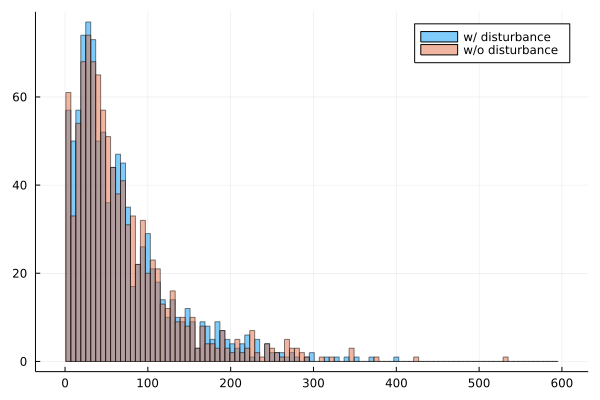

In [122]:
# p = histogram(plot_costs[1][2], label="$(plot_costs[1][1])", alpha=0.4, bins=100)
# for x in plot_costs[end:end]
#     histogram!(x[2], label="$(x[1])", alpha=0.4, bins=100)
# end
# p
histogram(baseline_costs, alpha=0.5, label="w/ disturbance", bins=1:6:600)
histogram!(baseline_costs_1, alpha=0.5, label="w/o disturbance", bins=1:6:600)

In [95]:
# Similarity metric for comparing a realized state to the stored tree states
function is_similar(state_a, state_b)
    e1 = norm(state_a[2]-state_b[2])
    e2 = norm(mean(state_a[3]) - mean(state_b[3]))
    return (e1<2 && e2<2)
end

is_similar (generic function with 2 methods)

In [96]:
# print("Starting grid search...")
# mc_samps = load("data/gridworld_baseline_10000000.jld2")["risks"]
# mc_samps = [Float64(samp) for samp in mc_samps]

# TISExperiments.run_grid_search(amdp, fixed_s, disturbance, mc_samps, ones(length(mc_samps)), path)
# TISExperiments.run_grid_search(amdp, tree_mdp, fixed_s, disturbance, mc_samps, ones(length(mc_samps)), path; N_l=[1_000_000], save_every=1)
# TISExperiments.run_grid_search(amdp, tree_mdp, fixed_s, disturbance, mc_samps, ones(length(mc_samps)), path; N_l=[10_000], α_l=[1e-2], β_a_l=[0.5], β_b_l=[0.3], schedule_l = [0.1])

# print("...Completed.")


# results_baseline, results_tis, planner = TISExperiments.run_baseline_and_treeIS(amdp, fixed_s, disturbance; N, c, α, β, γ, schedule, uniform_floor, baseline)

tree_mdp = construct_tree_amdp(amdp, disturbance; reduction="sum")
planner = TreeImportanceSampling.mcts_isdpw(tree_mdp; N=10, c, α)
tree_fixed_s = TreeImportanceSampling.TreeState(fixed_s);
traj_plots = [];

In [83]:
a, info = action_info(planner, tree_fixed_s; tree_in_info=true, N=10, c, α, β, γ, schedule, uniform_floor, baseline)
tis_output = (planner.mdp.costs, [], planner.mdp.IS_weights, info[:tree]);

"$(strategy_text) strategy" = "VaR strategy"


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


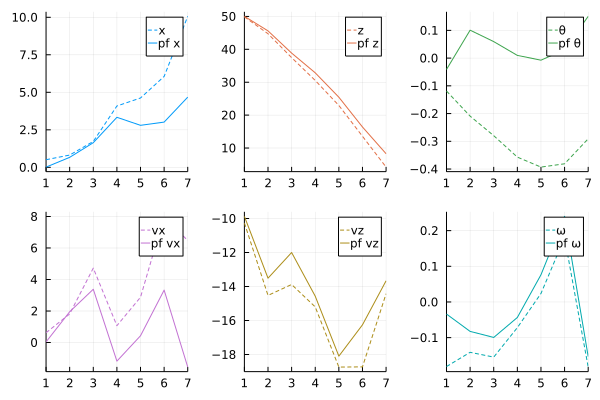

In [84]:
history = simulate(HistoryRecorder(), amdp, FunctionPolicy((s) -> TreeImportanceSampling.tree_policy(planner, s, is_similar; schedule=schedule)), fixed_s);
push!(traj_plots, plot_path(history))
traj_plots[end]
# planner.tree.cdf_est
# planner.tree.total_n
# planner.mdp.costs

In [85]:
D3Tree(planner.tree.dpw_tree)

Any[0, [0.5075988475000558, 49.86796558999886, -0.1187706044484646, 0.6219443502665454, -10.261628398735562, -0.18095812957335916], ParticleCollection{Vector{Float64}}([[-0.17583113688909272, 49.85947364372614, 0.0027155338009193846, -0.09470518485178311, -9.43779095667309, -0.11449015317288201], [-0.14818619126023333, 50.04937689836901, -0.2641991008076796, 0.31727444876110655, -9.657721009371835, 0.018702790710362998], [0.1638530336547197, 50.47161548646582, 0.036756274617482036, -0.2802427210015927, -9.783521632907968, -0.15905799749225552], [0.1298600017249805, 49.72919840615555, -0.10509877103612829, 0.1587714652472374, -10.0683836242635, -0.0706424272201435], [-1.371627888375463, 50.18019564065726, -0.14220589095735334, -0.11776349701060194, -9.883308702078937, -0.0007612980079313577], [0.17793150152769918, 50.033794980023345, 0.05694584949295476, 0.2153779650732072, -10.423468545550175, -0.023828371819888623], [0.32234955253215763, 50.221919579438925, -0.014521050140729616, 0.2033017146856342, -9.424671489064634, -0.036725989183435434], [0.23924811572395904, 50.027517132521744, -0.08511936279150269, 0.2922696753113607, -9.490212102333695, 0.04919924943476925], [-0.07149323228754427, 49.57257376560148, 0.030236550236536344, 0.3874601922598601, -10.144825261757784, -0.036873503034471296], [-0.1859132996889607, 50.281483361048004, 0.023942258932052794, -0.06170450171466039, -9.793147009405219, -0.08180579409672206], [-0.5219551365446191, 49.86940059737912, 0.0027291621540711814, 0.09410784550493724, -9.977431655348356, -0.08945184707955289], [-0.6307965477718579, 49.94077533975558, -0.058544317521836364, -0.4773150059564275, -10.034285350658982, -0.03714997240567266], [0.38245447877393174, 49.93548636958591, 0.0012484378414156184, 0.04445540223532013, -10.31382197761448, -0.11484589871168688], [0.43373039781222406, 49.98132110809427, -0.03530786655768097, -0.45817640368786533, -9.244874878391267, 0.012580788649805389], [0.10024603176057291, 50.087371366332675, -0.1625619456664758, -0.29640514048533545, -10.294247684806168, -0.19905539723314605], [0.043493904302206114, 50.995983358387264, -0.07214121984874265, -0.1824927343527829, -9.854730094990996, 0.024720770605505336], [-0.008115193086079813, 49.8001184475391, -0.10204193548690513, -0.4147351817722585, -9.782730512081411, -0.009460071173365794], [-0.09004513656353229, 49.8928738228836, -0.009536748694092163, 0.24317016287522264, -9.543859281945302, -0.027503213774867398], [-0.12005191608912029, 49.771463357116595, 0.013966112558116068, -0.4456722011262317, -9.666235305962502, -0.22378222313138882], [-0.21823352609227006, 49.562931772079104, 0.05938504216651738, 0.20902530751999038, -9.1275540092145, 0.04676355606995634], [-0.025489691699574706, 50.02516265429278, -0.036251216727772734, -0.21766931283372246, -10.220020823945836, -0.0429894158819723], [-0.19511863899977647, 49.750958578596915, 0.09793681640487545, -0.05277525536715945, -10.139467629700576, -0.00106585238662763], [0.1288756596343018, 49.87904727602127, -0.04306357340413131, -0.01673632232173867, -9.75868450676099, -0.17078224461664115], [-0.2103078960575181, 50.50438988005688, 0.05424677877448506, 0.08547345619287958, -9.631993013060995, -0.09752391996154888], [0.1869824335019478, 49.816220296717006, -0.10412662750801527, -0.060858959298403306, -10.137499058672416, 0.008422740657017527], [0.33008250539665823, 49.84418907155558, 0.12458570216388754, 0.3543430626201512, -10.038993615344898, -0.10664768973086368], [0.09635505693002494, 49.43046546523781, -0.013268665889419915, 0.1993168866217409, -10.740530100383603, -0.015973244410747055], [0.21488681419706654, 49.76448477528101, 0.12306970723625588, 0.34487725517969187, -9.400475146076564, -0.026786676662796844], [0.6449234956973293, 50.01762664055568, -0.07193540879657702, -0.05151068294064357, -10.09116182867199, -0.20534491466053764], [-0.7062375120034062, 49.635260124968816, -0.15591843759684126, -0.42764855941506863, -10.112321405907592, -0.16530342319

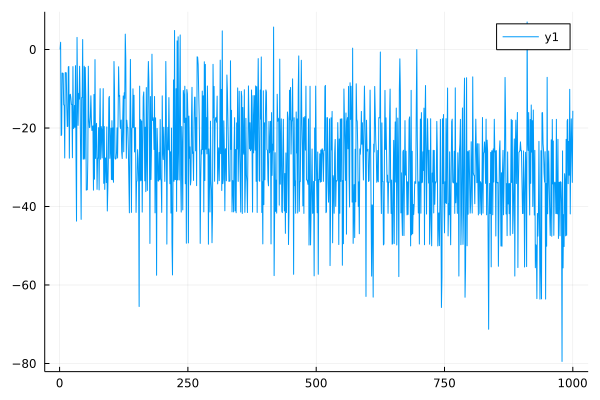

In [59]:
plot(planner.mdp.IS_weights)

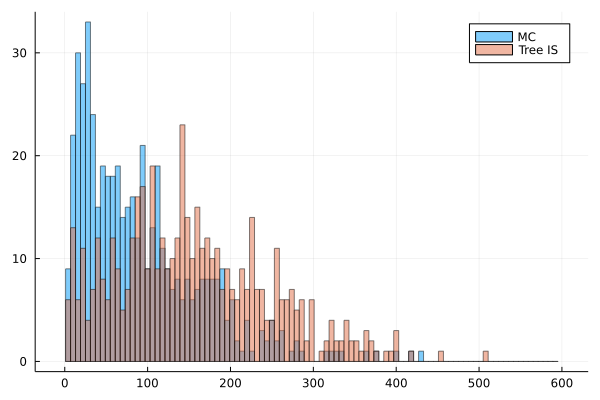

In [67]:
tis_range = (500, length(tis_output[1]))
histogram(baseline_costs[tis_range[1]:tis_range[2]], alpha=0.5, label="MC", bins=1:6:600)
histogram!(planner.mdp.costs[tis_range[1]:tis_range[2]], alpha=0.5, label="Tree IS", bins=1:6:600)

In [523]:

# print("Baseline metrics")

# TISExperiments.evaluate_metrics(baseline_costs; alpha_list=[1e-3])

# print("\nTIS metrics: N=$(N), c=$(c), α=$(α), β=$(β)), γ=$(γ)")

# TISExperiments.evaluate_metrics(tis_output[1][tis_range[1]:tis_range[2]]; weights=exp.(tis_output[3][tis_range[1]:tis_range[2]]), alpha_list=[1e-3])

# if baseline
# save("$(path)_baseline_$(N).jld2", Dict("risks" => baseline_costs, "states" => []))
# # else
# #     save("$(path)_mcts_IS_$(N).jld2", Dict("risks" => results_tis[1], "states" => results_tis[2], "IS_weights" => results_tis[3], "tree" => results_tis[4]))
# # end

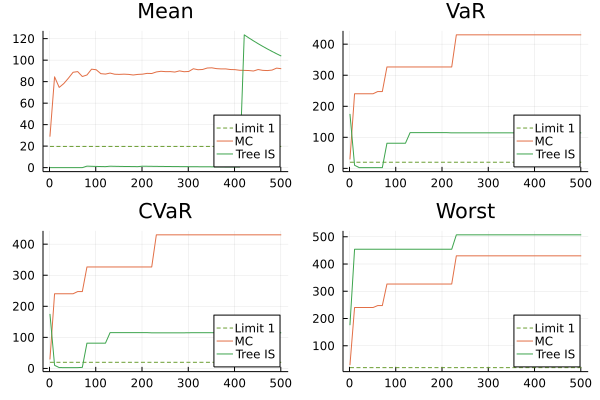

In [68]:
TISExperiments.plot_metrics([baseline_costs, baseline_costs, tis_output[1]]; weights_l=[nothing, nothing, exp.(tis_output[3])], range_l = tis_range, alpha=1e-3, names=["Limit", "MC", "Tree IS"], N_list = [2^i for i=1:10])

LoadError: UndefVarError: plot not defined